In [1]:
! huggingface-cli login


/bin/bash: line 1: huggingface-cli: command not found


In [3]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

dataset = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [8]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [9]:
dataset['train'][0].keys()

dict_keys(['image_file_path', 'image', 'labels'])

## Understanding data Structure

In [11]:
from PIL import Image
import numpy as np

print("# of class:", len(dataset['train'].features['labels'].names))
print("# of train img:", len(dataset['train']))

widths, heights = [], []

for data in dataset['train']:
    with Image.open(data['image_file_path']) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)
print("avg width:", np.mean(widths))
print("ave height:", np.mean(heights))

# of class: 3
# of train img: 1034
avg width: 500.0
ave height: 500.0


## Data Visualization

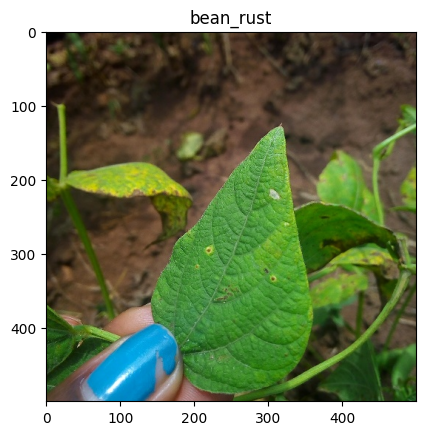

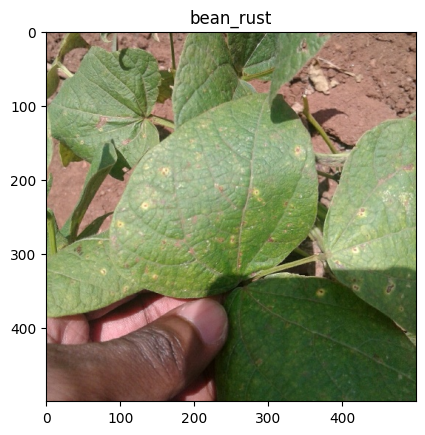

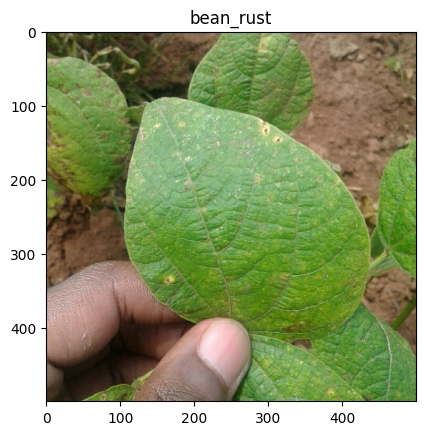

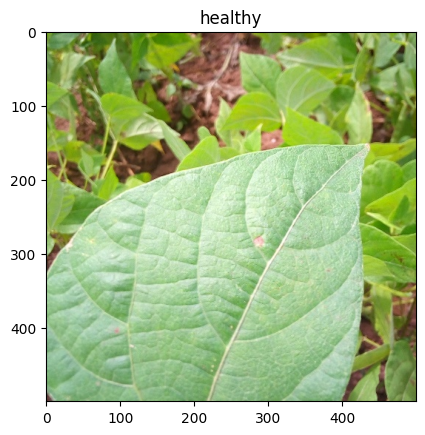

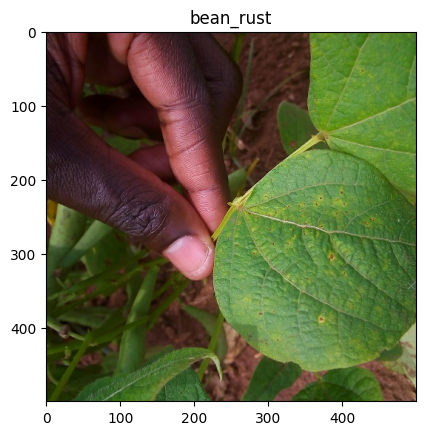

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

sample_data = dataset['train'].shuffle().select(range(5))
for data in sample_data:
    image = Image.open(data['image_file_path'])
    label = dataset['train'].features['labels'].names[data['labels']]



    plt.imshow(image)
    plt.title(label)
    plt.show()


## Class Distribution

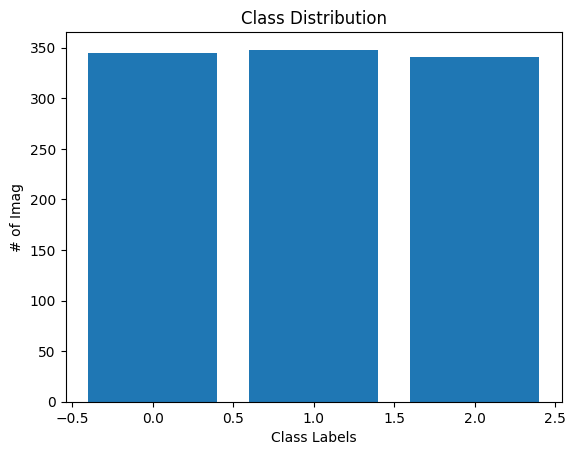

In [13]:
import numpy as np


labels = [data['labels'] for data in dataset['train']]
unique, counts = np.unique(labels, return_counts=True)



plt.bar(unique, counts)
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("# of Imag")
plt.show()


## Image Augmentation

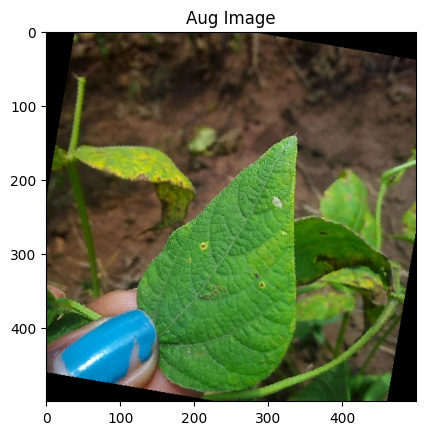

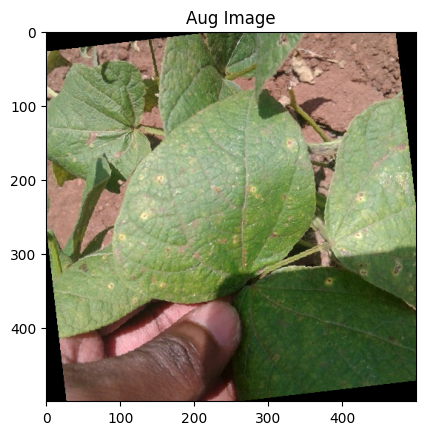

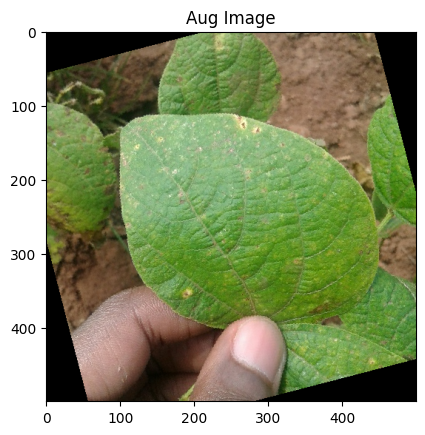

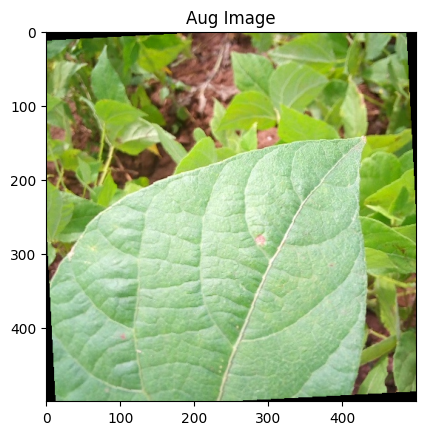

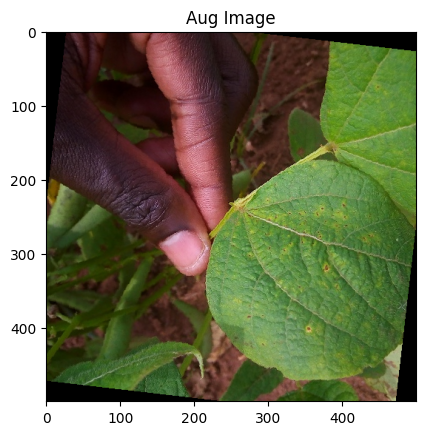

In [14]:
from torchvision.transforms import RandomRotation

transform = RandomRotation(30)

for data in sample_data:
    image = Image.open(data['image_file_path'])
    augmented_image = transform(image)
    plt.imshow(augmented_image)
    plt.title("Aug Image")
    plt.show()


## feature distribution

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 248MB/s]


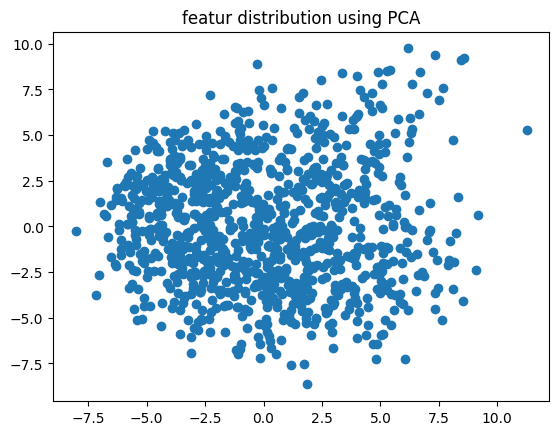

In [15]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(pretrained=True).to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1])).eval()



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



features = []
for data in dataset['train']:
    image = Image.open(data['image_file_path']).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(tensor)
    features.append(feature.cpu().squeeze().numpy())



pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title("featur distribution using PCA")
plt.show()

## find duplicate images

In [16]:
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.0 MB/s eta 0:00:00


In [17]:
import imagehash


hashes = {}
duplicates = []



for data in dataset['train']:
    image = Image.open(data['image_file_path']).convert('RGB')
    h = imagehash.phash(image)
    if h in hashes:
        duplicates.append((data['image_file_path'], hashes[h]))
    else:
        hashes[h] = data['image_file_path']


print(f"Found {len(duplicates)} duplicate pairs.")
for pair in duplicates:
    print("duplicate pair:", pair)

Found 0 duplicate pairs.
